## 1. Sobre o Documento
---
Este documento não tem por objetivo demonstrar todas as funcionalidades, apenas os métodos principais para descobrir a sintaxe e o funcionamento padrão do DuckDB.

## 2. Instalação
---
Instalando dependências necessárias para este pequeno guia prático de principais funcionalidades.

In [ ]:
!pip install duckdb pandas -q

## 3. Conexão com DuckDB e Google Drive
---
Conectando o DuckDB em memória para conseguir fazer as querys.

In [ ]:
import duckdb

# Conexão em memória (mais comum no Colab)
con = duckdb.connect(database=':memory:', read_only=False)

# Conexão persistente (salva em arquivo)
# con = duckdb.connect("/content/meubanco.duckdb")

In [ ]:
# Se adicionar o arquivo ao Drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## 4. Carregando o DataFrame com Pandas
---
Carregando a DataBase em Pandas. Por conta do tamanho, demorará ou levantará um erro.

In [ ]:
import pandas as pd

file_path = '././base_dados/base_vendas_sintetica.csv'

# Carregar com Pandas
try:
    df = pd.read_csv(file_path)
    print(f"Dados carregados com sucesso: {file_path}")
    display(df.head())
except FileNotFoundError:
    print(f"Erro: Arquivo não encontrado em {file_path}")
except Exception as e:
    print(f"Erro: {e}")

Dados carregados com sucesso: /content/drive/MyDrive/IBMEC 2025.2/Programação Para Análise de Dados/Seminário/base_vendas_sintetica.csv


,Order_ID,Customer_ID,Customer_Type,Product,Category,Unit_Price,Quantity,Discount,Total_Price,Region,Order_Date
0,ORD1,CUS1496,B2B,Vio Wasser,Water,1.66,53,0.10,79.18,Baden-Württemberg,2023-08-23
1,ORD1,CUS1496,B2B,Evian,Water,1.56,90,0.10,126.36,Baden-Württemberg,2023-08-23
2,ORD1,CUS1496,B2B,Sprite,Soft Drinks,1.17,73,0.05,81.14,Baden-Württemberg,2023-08-23
3,ORD1,CUS1496,B2B,Rauch Multivitamin,Juices,3.22,59,0.10,170.98,Baden-Württemberg,2023-08-23
4,ORD1,CUS1496,B2B,Gerolsteiner,Water,0.87,35,0.10,27.40,Baden-Württemberg,2023-08-23


## 5. Carregando o DataFrame com DuckDB
---
Carregando a DataBase rapidamente com DuckDB.

In [ ]:
# Caminho do arquivo
file_path = '././base_dados/base_vendas_sintetica.csv'

# Carregando para memória o arquivo CSV
try:
    # read_csv_auto automaticamente detecta formatação e carrega os dados
    con.execute(f"CREATE OR REPLACE TABLE base_vendas AS SELECT * FROM read_csv_auto('{file_path}')")

    # DuckDB query e visualização dos dados
    result_df = con.execute("SELECT * FROM base_vendas LIMIT 10").fetchdf()
    display(result_df)

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,Order_ID,Customer_ID,Customer_Type,Product,Category,Unit_Price,Quantity,Discount,Total_Price,Region,Order_Date
0,ORD1,CUS1496,B2B,Vio Wasser,Water,1.66,53,0.10,79.18,Baden-Württemberg,2023-08-23
1,ORD1,CUS1496,B2B,Evian,Water,1.56,90,0.10,126.36,Baden-Württemberg,2023-08-23
2,ORD1,CUS1496,B2B,Sprite,Soft Drinks,1.17,73,0.05,81.14,Baden-Württemberg,2023-08-23
3,ORD1,CUS1496,B2B,Rauch Multivitamin,Juices,3.22,59,0.10,170.98,Baden-Württemberg,2023-08-23
4,ORD1,CUS1496,B2B,Gerolsteiner,Water,0.87,35,0.10,27.40,Baden-Württemberg,2023-08-23
5,ORD2,CUS2847,B2C,Sauvignon Blanc,Alcoholic Beverages,9.09,2,0.00,18.18,Schleswig-Holstein,2023-03-16
6,ORD3,CUS1806,B2B,Tomato Juice,Juices,2.14,44,0.10,84.74,Hamburg,2022-11-20
7,ORD3,CUS1806,B2B,Vittel,Water,0.43,13,0.05,5.31,Hamburg,2022-11-20
8,ORD3,CUS1806,B2B,San Pellegrino,Water,1.21,92,0.10,100.19,Hamburg,2022-11-20
9,ORD3,CUS1806,B2B,Evian,Water,1.38,3,0.05,3.93,Hamburg,2022-11-20


## 6. Iniciando Análise Exploratória
---
Aqui iniciamos o processo de análise exploratória com DuckDB.

#### **6.1. Ticket Médio (B2B + B2C)**

In [ ]:
# Ticket Médio
display(con.execute(f"SELECT AVG(Total_Price) AS 'Ticket Médio' FROM base_vendas").fetchdf().round(2))

,Ticket Médio
0,130.74


#### **6.2. Estatísticas Descritivas**

In [ ]:
def desc_stats(nome_tabela, nome_coluna, arr=2):
    """
    Calcula estatísticas descritivas (count, mean, min, max, std, quartis)
    para uma coluna numérica específica em uma tabela DuckDB.
    """

    query = f"""
    SELECT
        COUNT("{nome_coluna}") AS count,
        AVG("{nome_coluna}") AS média,
        MIN("{nome_coluna}") AS mínimo,
        MAX("{nome_coluna}") AS máximo,
        STDDEV_POP("{nome_coluna}") AS desv_pad,
        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY "{nome_coluna}") AS "25%",
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY "{nome_coluna}") AS "50%",
        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY "{nome_coluna}") AS "75%"
    FROM "{nome_tabela}"
    """

    return con.execute(query).fetchdf().round(arr)

In [ ]:
# Exemplo de uso com a tabela 'base_vendas' e a coluna 'Total_Price'
print("Estatísticas descritivas para a coluna 'Total_Price' na tabela 'base_vendas':")
display(desc_stats('base_vendas', 'Total_Price'))

Estatísticas descritivas para a coluna 'Total_Price' na tabela 'base_vendas':


,count,média,mínimo,máximo,desv_pad,25%,50%,75%
0,8999910,130.74,0.3,14295.3,509.69,8.4,21.14,69.49


#### **6.3. Ticket Médio por Tipo de Cliente**

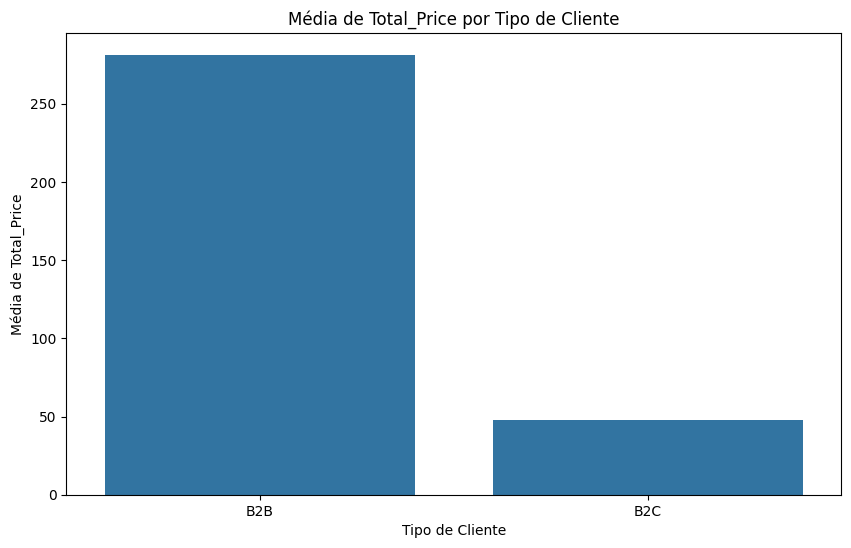

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obter a média de Total_Price por Customer_Type usando DuckDB
query_media_preco_por_tipocliente = """
SELECT Customer_Type, AVG(Total_Price) AS Average_Total_Price
FROM base_vendas
GROUP BY Customer_Type
ORDER BY Average_Total_Price DESC
"""
media_preco_tipocliente = con.execute(query_media_preco_por_tipocliente).fetchdf()

# Criar o gráfico de barras usando seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Customer_Type', y='Average_Total_Price', data=media_preco_tipocliente)

plt.title('Média de Total_Price por Tipo de Cliente')
plt.xlabel('Tipo de Cliente')
plt.ylabel('Média de Total_Price')
plt.show()

#### **6.4. Categorias Mais Vendidas por Tipo de Cliente**

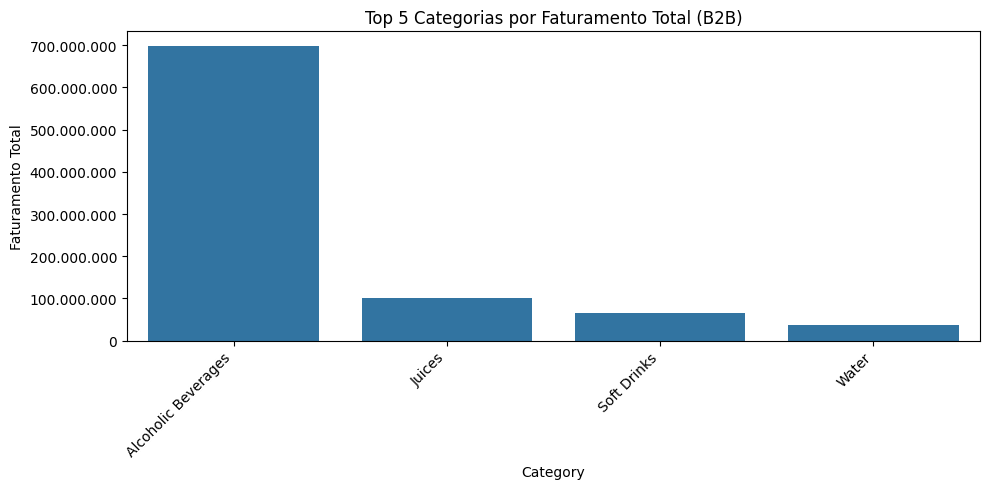

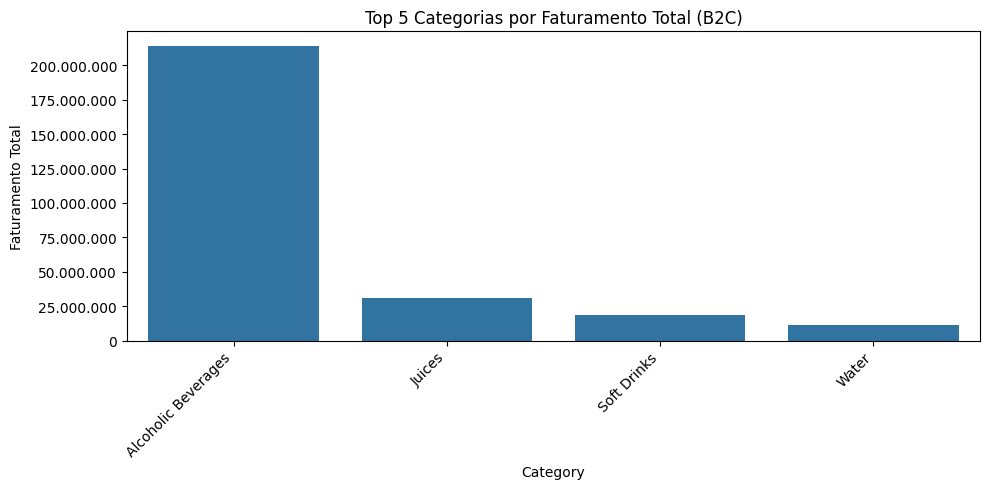

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as mticker

# Function to get top categories by revenue for a given customer type
def get_top_categories_by_customer_type(customer_type, limit=5):
    query = f"""
    SELECT Category, SUM(Total_Price) AS Total_Revenue
    FROM base_vendas
    WHERE Customer_Type = '{customer_type}'
    GROUP BY Category
    ORDER BY Total_Revenue DESC
    LIMIT {limit}
    """
    return con.execute(query).fetchdf()

# Get top categories for B2B and B2C
top_categories_b2b_df = get_top_categories_by_customer_type('B2B')
top_categories_b2c_df = get_top_categories_by_customer_type('B2C')

# Create plot for B2B
plt.figure(figsize=(10, 5))
sns.barplot(x='Category', y='Total_Revenue', data=top_categories_b2b_df)
plt.title('Top 5 Categorias por Faturamento Total (B2B)')
plt.ylabel('Faturamento Total')
plt.xticks(rotation=45, ha='right')

plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', '.')))
plt.tight_layout()
plt.show()

# Create plot for B2C
plt.figure(figsize=(10, 5))
sns.barplot(x='Category', y='Total_Revenue', data=top_categories_b2c_df)
plt.title('Top 5 Categorias por Faturamento Total (B2C)')
plt.ylabel('Faturamento Total')
plt.xticks(rotation=45, ha='right')

plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', '.')))
plt.tight_layout()
plt.show()

#### **6.5. Vendas por Data**

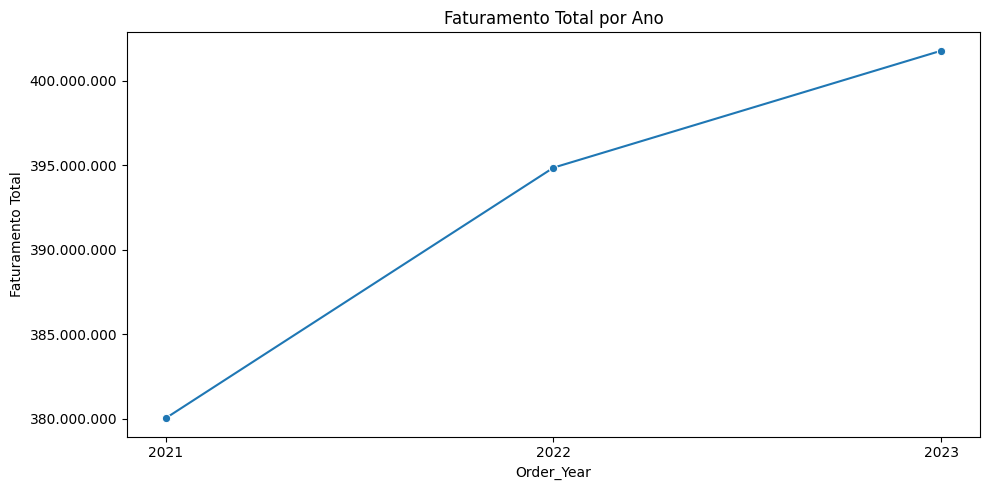

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as mticker

# Obter o faturamento total por ano com desconto
query_revenue_by_year = """
SELECT strftime('%Y', Order_Date) AS Order_Year,
       SUM(Total_Price) AS Total_Revenue
FROM base_vendas
GROUP BY Order_Year
ORDER BY Order_Year
"""
revenue_by_year_df = con.execute(query_revenue_by_year).fetchdf()

# Criar o gráfico de barras ou linha (linha é melhor para séries temporais)
plt.figure(figsize=(10, 5))
sns.lineplot(x='Order_Year', y='Total_Revenue', data=revenue_by_year_df, marker='o')

plt.title('Faturamento Total por Ano')
plt.ylabel('Faturamento Total')
# Format y-axis labels to avoid scientific notation and add thousand separators
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', '.')))
plt.tight_layout()
plt.show()

#### **6.6. Regiões com Maior Número de Vendas**

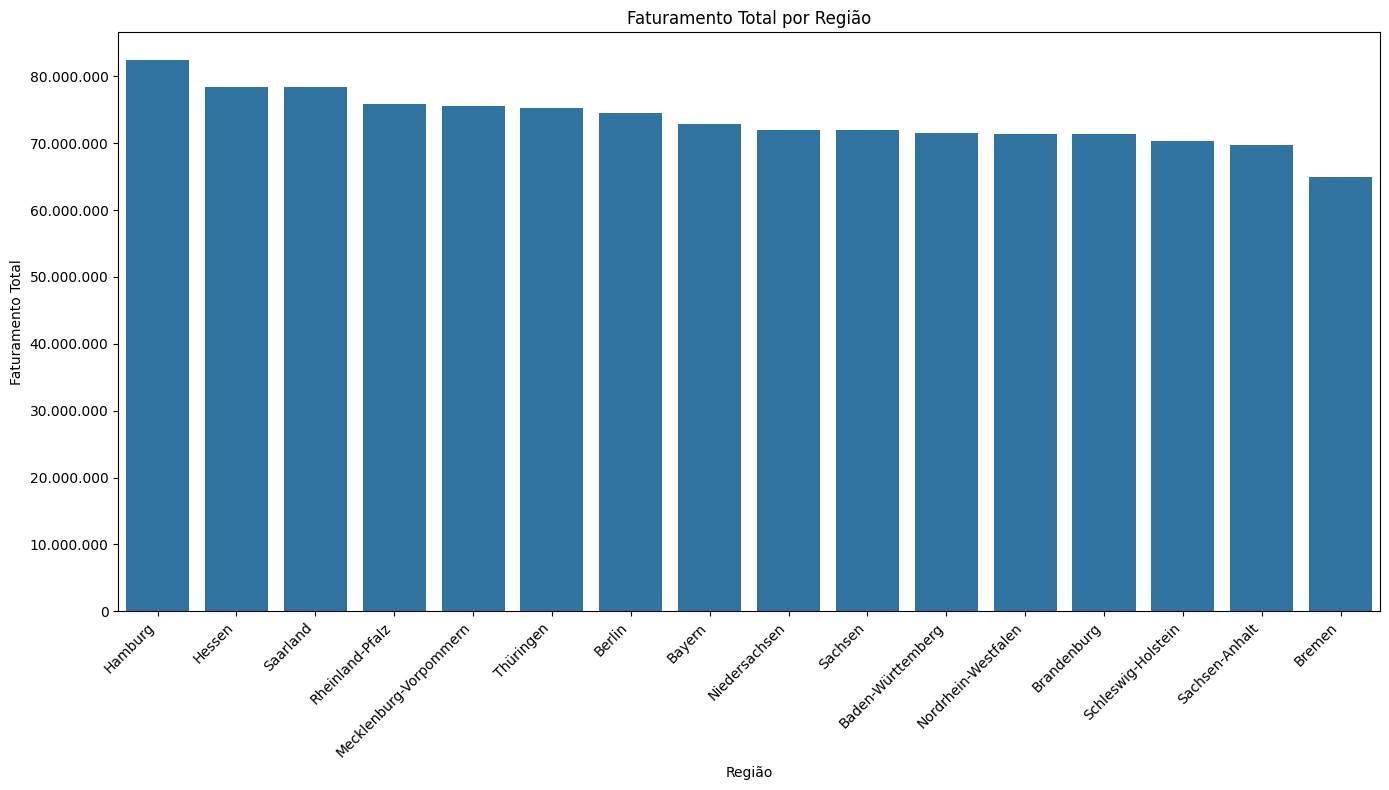

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as mticker

# Obter o faturamento total por região com desconto
query_revenue_by_region = """
SELECT Region, SUM(Total_Price) AS Total_Revenue
FROM base_vendas
GROUP BY Region
ORDER BY Total_Revenue DESC
"""
revenue_by_region_df = con.execute(query_revenue_by_region).fetchdf()

# Criar o gráfico de barras
plt.figure(figsize=(14, 8))
sns.barplot(x='Region', y='Total_Revenue', data=revenue_by_region_df)

plt.title('Faturamento Total por Região')
plt.xlabel('Região')
plt.ylabel('Faturamento Total')
plt.xticks(rotation=45, ha='right')
# Format y-axis labels to avoid scientific notation and add thousand separators
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f')) # Format as integer
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', '.'))) # Add thousand separators
plt.tight_layout()
plt.show()